In [1]:
# Import necessary libraries
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torch.nn as nn
from torch.optim import Adam, SGD
import random
from torchsummary import summary
import torchvision.models as models

In [2]:
# Assign device to gpu
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
device

device(type='cuda')

In [3]:
# Load the CIFAR-100 training set and split it into a training set of 40,000 images and a validation set of 10,000 images
transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

# Compute mean and standard deviation of pixel values in CIFAR-100 training set

mean = torch.zeros(3)
std = torch.zeros(3)
for i, (image, label) in enumerate(trainset):
    for j in range(3):
        mean[j] += image[j, :, :].mean()
        std[j] += image[j, :, :].std()

mean.div_(len(trainset))
std.div_(len(trainset))

print('Mean of pixel values:', mean)
print('Standard deviation of pixel values:', std)

Files already downloaded and verified
Files already downloaded and verified
Mean of pixel values: tensor([0.4382, 0.4178, 0.3772])
Standard deviation of pixel values: tensor([0.2572, 0.2489, 0.2413])


In [4]:
# Load the CIFAR-100 training set and split it into a training set of 40,000 images and a validation set of 10,000 images
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

batch_size=512

trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
# Load the validation set into a data loader with the specified batch size and 2 worker threads for parallel loading
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
# Define a tuple of the 100 categories in the CIFAR-100 dataset
classes = trainset.dataset.classes

Files already downloaded and verified
Files already downloaded and verified


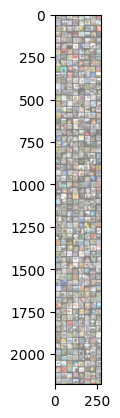

tank  plate fox   man   flatfish sea   turtle sweet_pepper skyscraper castle palm_tree pickup_truck snake sunflower lamp  rocket cattle wardrobe forest woman clock snake skyscraper hamster man   elephant wolf  table plate streetcar hamster rose  chair cattle shrew can   maple_tree whale maple_tree man   road  mouse camel cockroach skyscraper bed   lawn_mower crocodile bee   apple mouse bicycle seal  keyboard streetcar mountain dolphin crocodile clock cup   palm_tree rabbit raccoon squirrel road  can   dolphin train mouse maple_tree willow_tree lion  sweet_pepper pine_tree orange bear  crab  pear  orange maple_tree streetcar flatfish wardrobe streetcar train man   rocket plain woman forest squirrel bicycle bowl  palm_tree bee   beaver cloud camel possum telephone chimpanzee flatfish snake snail palm_tree aquarium_fish elephant rabbit motorcycle aquarium_fish skunk possum bowl  cloud cattle dinosaur motorcycle cup   bottle bus   lobster wolf  keyboard camel butterfly worm  whale televisi

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Define a helper function to display images
def imshow(img):
    # Unnormalize the image
    img = img / 2 + 0.5
    # Convert the image to a numpy array
    npimg = img.numpy()
    # Transpose the array to change the order of dimensions (3, 32, 32 --> 32, 32, 3)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# Get a batch of random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show the images using the helper function defined above
imshow(torchvision.utils.make_grid(images))

# Print the labels for each image in the batch
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [6]:
def train(dl, model, optimizer, L, n_epochs=10, valdl=None):    
    # Loop over the number of epochs
    for epoch in range(n_epochs):
        # Set the model to train mode
        model.train()
        train_loss, train_acc = 0.0, 0.0
        model.trainedepoch += 1
        for x, y in dl:
            # Move data to device (Data and the model has to be assigned to the same device)
            x = x.to(device)
            y = y.to(device)
            
            # Zero out the optimizer gradients at the beginning of each epoch
            optimizer.zero_grad()
            
            out = model(x)
            loss = L(out, y)
            loss.backward()
            optimizer.step()
            
            _, preds = torch.max(out, dim=1)
            train_loss += loss.item()            
            train_acc += torch.sum(preds == y.data)
            
        
        train_loss /= len(dl)
        model.trainloss.append(train_loss)
        
        train_acc = train_acc.float() / len(dl.dataset)
        model.trainacc.append(train_acc.item())
        # If a validation data loader is provided
        if valdl:
            # Disable gradient computation
            model.eval()
            val_loss, val_acc = 0.0, 0.0
            
            with torch.no_grad():
                for valx, valy in valdl:
                    # Move data to device
                    valx = valx.to(device)
                    valy = valy.to(device)

                    out = model(valx)
                    loss = L(out, valy)
                    
                    _, preds = torch.max(out, dim=1)
                    val_loss += loss.item()
                    val_acc += torch.sum(preds == valy.data)
            
            val_loss /= len(valdl)
            model.valloss.append(val_loss)
            
            val_acc = val_acc.float() / len(valdl.dataset)
            model.valacc.append(val_acc.item()) 
                
            # Print the epoch number, training loss, and validation loss
            print(f'Epoch {model.trainedepoch}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f},Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')
            
        # If no validation data loader is provided
        else:
            # Print the epoch number and training loss
            print(f'Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}')

In [7]:
def evaluate(dl, model):
    # Set the model to evaluation mode
    model.eval()
    
    # Initialize variables to track correct and incorrect predictions
    true, false = 0, 0
    
    # Loop over the data loader
    for xs, ys in dl:
        # Move data to device
        xs, ys = xs.to(device), ys.to(device)
        
        # Forward pass
        preds = model(xs)
        
        # Convert predictions to class labels
        preds = [pred.argmax() for pred in preds]
        
        # Loop over the predictions and true labels
        for pred, y in zip(preds, ys):
            
            # Increment the correct count if the prediction is correct
            if pred == y:
                true += 1
            # Increment the incorrect count if the prediction is incorrect
            else:
                false += 1
                
    # Compute the accuracy
    accuracy = true/(true+false)
    
    # Return the accuracy
    return accuracy 

## To see different results of different models, we have trained 6 models. 
## 1. A simple 3 layered linear neural network
## 2. A custom convolutional neural network with 4 conv layer with maxpooling and 2 fully connected linear layers afterwards.
## 3. A custom ResNet with a similar architecture with ResNet18 but smaller.
## 4. ResNet18 (fine tuning)
#### We did not froze any layers. Instead, we tuned the parameters which were initially trained with Imagenet dataset for Cifar100 dataset.
## 5. ResNet50 (fine tuning)
#### Same approach as the 4th model.
## 6. ResNet50 (pretrained) 
#### This time first we upslaced the Cifar100 images before entering the model. Because the model was trained with higher resolution images.
#### By doing that, we will get more benefit from pretrained feature extracter conv layers. Additionally, we froze every layer except batch norm layers and the final linear layer.
#### Because we know that the batch normalization layers that trained with different datasets may be problematic when using new datasets.
####
#### In this project, we increased the model complexity with each model and the best performing model was the last one with TrainAcc:0.9839 ValAcc:0.7371 TestAcc:0.7239

## MODEL 1 : Linear NN

In [13]:
class Linear_NN(nn.Module):
    def __init__(self):
        super(Linear_NN, self).__init__()
        self.layer_1 = nn.Linear(in_features=32*32*3,out_features=512)
        self.hidden_layer = nn.Linear(512, 256)
        self.output_layer = nn.Linear(256, 100)
    
    def forward(self, ip):

        output = ip.view(-1, 32*32*3)
        output = self.layer_1(output)
        output = self.hidden_layer(output)
        output=self.output_layer(output)
        
        return output
    
model = Linear_NN()
model = model.to(device)
summary(model, (3, 32, 32))
model.trainedepoch = 0
model.trainloss, model.valloss, model.trainacc, model.valacc = [], [], [], []

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]       1,573,376
            Linear-2                  [-1, 256]         131,328
            Linear-3                  [-1, 100]          25,700
Total params: 1,730,404
Trainable params: 1,730,404
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.01
Params size (MB): 6.60
Estimated Total Size (MB): 6.62
----------------------------------------------------------------


In [14]:
# Initialize the Adam optimizer with it's default values and model parameters
# optimizer = SGD(model.parameters(), lr = 0.2)
optimizer = Adam(model.parameters())
L = nn.CrossEntropyLoss()

In [15]:
train(trainloader, model, optimizer, L, n_epochs=50, valdl=valloader)

Epoch 1, Train Loss: 4.2560, Train Accuracy: 0.0590,Val Loss: 4.1015, Val Accuracy: 0.0756
Epoch 2, Train Loss: 4.0267, Train Accuracy: 0.0903,Val Loss: 4.0775, Val Accuracy: 0.0870
Epoch 3, Train Loss: 3.9911, Train Accuracy: 0.0992,Val Loss: 4.0168, Val Accuracy: 0.0933
Epoch 4, Train Loss: 3.9643, Train Accuracy: 0.1050,Val Loss: 3.9864, Val Accuracy: 0.1081
Epoch 5, Train Loss: 3.9358, Train Accuracy: 0.1105,Val Loss: 4.0585, Val Accuracy: 0.0788
Epoch 6, Train Loss: 3.9325, Train Accuracy: 0.1099,Val Loss: 3.9112, Val Accuracy: 0.1111
Epoch 7, Train Loss: 3.9007, Train Accuracy: 0.1203,Val Loss: 3.9677, Val Accuracy: 0.1134
Epoch 8, Train Loss: 3.9220, Train Accuracy: 0.1160,Val Loss: 3.9774, Val Accuracy: 0.0960
Epoch 9, Train Loss: 3.9044, Train Accuracy: 0.1180,Val Loss: 3.9739, Val Accuracy: 0.1076
Epoch 10, Train Loss: 3.8944, Train Accuracy: 0.1199,Val Loss: 3.8946, Val Accuracy: 0.1154
Epoch 11, Train Loss: 3.8818, Train Accuracy: 0.1229,Val Loss: 3.9116, Val Accuracy: 0.11

In [26]:
train(trainloader, model, optimizer, L, n_epochs=50, valdl=valloader)

Epoch 51, Train Loss: 3.8152, Train Accuracy: 0.1358,Val Loss: 3.8406, Val Accuracy: 0.1274
Epoch 52, Train Loss: 3.8175, Train Accuracy: 0.1331,Val Loss: 3.8459, Val Accuracy: 0.1279
Epoch 53, Train Loss: 3.8050, Train Accuracy: 0.1372,Val Loss: 3.8284, Val Accuracy: 0.1303
Epoch 54, Train Loss: 3.8150, Train Accuracy: 0.1381,Val Loss: 3.8469, Val Accuracy: 0.1273
Epoch 55, Train Loss: 3.8130, Train Accuracy: 0.1367,Val Loss: 3.7965, Val Accuracy: 0.1416
Epoch 56, Train Loss: 3.8171, Train Accuracy: 0.1376,Val Loss: 3.8166, Val Accuracy: 0.1345
Epoch 57, Train Loss: 3.8152, Train Accuracy: 0.1361,Val Loss: 3.8340, Val Accuracy: 0.1307
Epoch 58, Train Loss: 3.8157, Train Accuracy: 0.1356,Val Loss: 3.8285, Val Accuracy: 0.1318
Epoch 59, Train Loss: 3.8060, Train Accuracy: 0.1383,Val Loss: 3.8479, Val Accuracy: 0.1301
Epoch 60, Train Loss: 3.8013, Train Accuracy: 0.1397,Val Loss: 3.8146, Val Accuracy: 0.1369
Epoch 61, Train Loss: 3.8101, Train Accuracy: 0.1390,Val Loss: 3.8429, Val Accur

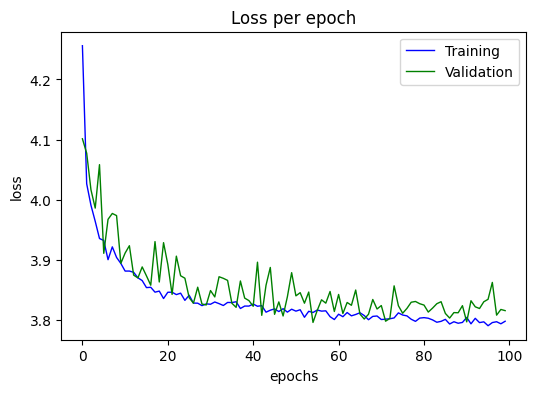

In [27]:
plt.figure(figsize=(6,4))
plt.plot(range(model.trainedepoch), model.trainloss, 'b', label = "Training",linewidth = '1')
plt.plot(range(model.trainedepoch), model.valloss, 'g', label = "Validation",linewidth = '1')

plt.title("Loss per epoch",)
plt.xlabel("epochs",)  
plt.ylabel("loss",)
plt.legend()
plt.show()

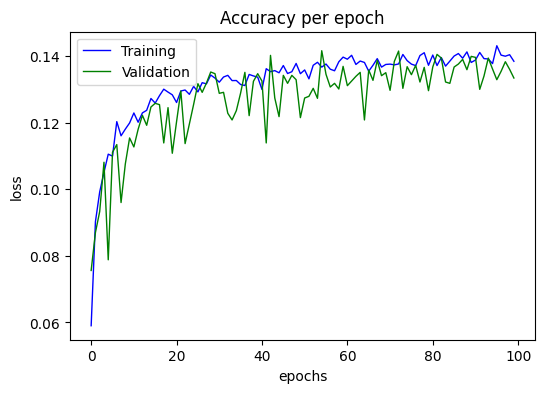

In [36]:
plt.figure(figsize=(6,4))
plt.plot(range(model.trainedepoch), model.trainacc, 'b', label = "Training",linewidth = '1')
plt.plot(range(model.trainedepoch), model.valacc, 'g', label = "Validation",linewidth = '1')

plt.title("Accuracy per epoch",)
plt.xlabel("epochs",)  
plt.ylabel("loss",)
plt.legend()
plt.show()

In [55]:
print(evaluate(trainloader, model), evaluate(valloader, model), evaluate(testloader, model))

0.134875 0.1333 0.1298


## MODEL 2: CNN

In [37]:
class cnn(nn.Module):
    def __init__(self):
        super(cnn, self).__init__()
        '''
         Convolutional layers
         Conv2d (input channels, output channels, kernel_size, padding) 

        Each Sequential layer has :
              1. A Convolutional Layer
              2. Relu activation function
              3. Maxpool layer
        '''

        self.conv_layer_1 = torch.nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16,kernel_size= 3,stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.conv_layer_2 = torch.nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32,kernel_size= 3,stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )


        self.conv_layer_3 = torch.nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64,kernel_size= 3,stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.conv_layer_4 = torch.nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128,kernel_size= 3,stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        # Fully Connected layers
        self.hidden_layer = nn.Linear(128*2*2, 206)
        self.output_layer = nn.Linear(206, 100)
        
    def forward(self, ip):

        # Calling all the convolutional layers
        output = self.conv_layer_1(ip)
        output = self.conv_layer_2(output)
        output = self.conv_layer_3(output)
        output = self.conv_layer_4(output)
        
        # Flattening 
        output = output.view(-1, 128*2*2)
        
        # Call fully connected layer
        output = self.hidden_layer(output)
        
        output=self.output_layer(output)
   
        return output

model2 = cnn()
model2 = model2.to(device)
summary(model2, (3, 32, 32))
model2.trainedepoch = 0
model2.trainloss, model2.valloss, model2.trainacc, model2.valacc = [], [], [], []

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
              ReLU-2           [-1, 16, 32, 32]               0
         MaxPool2d-3           [-1, 16, 16, 16]               0
            Conv2d-4           [-1, 32, 16, 16]           4,640
              ReLU-5           [-1, 32, 16, 16]               0
         MaxPool2d-6             [-1, 32, 8, 8]               0
            Conv2d-7             [-1, 64, 8, 8]          18,496
              ReLU-8             [-1, 64, 8, 8]               0
         MaxPool2d-9             [-1, 64, 4, 4]               0
           Conv2d-10            [-1, 128, 4, 4]          73,856
             ReLU-11            [-1, 128, 4, 4]               0
        MaxPool2d-12            [-1, 128, 2, 2]               0
           Linear-13                  [-1, 206]         105,678
           Linear-14                  [

In [38]:
optimizer = Adam(model2.parameters())
L = nn.CrossEntropyLoss()

In [39]:
train(trainloader, model2, optimizer, L, n_epochs=100, valdl=valloader)

Epoch 1, Train Loss: 4.3363, Train Accuracy: 0.0400,Val Loss: 4.1794, Val Accuracy: 0.0621
Epoch 2, Train Loss: 3.9722, Train Accuracy: 0.0835,Val Loss: 3.8529, Val Accuracy: 0.0985
Epoch 3, Train Loss: 3.7832, Train Accuracy: 0.1149,Val Loss: 3.7384, Val Accuracy: 0.1244
Epoch 4, Train Loss: 3.6489, Train Accuracy: 0.1389,Val Loss: 3.5509, Val Accuracy: 0.1605
Epoch 5, Train Loss: 3.5287, Train Accuracy: 0.1584,Val Loss: 3.4656, Val Accuracy: 0.1687
Epoch 6, Train Loss: 3.4285, Train Accuracy: 0.1767,Val Loss: 3.4357, Val Accuracy: 0.1755
Epoch 7, Train Loss: 3.3461, Train Accuracy: 0.1927,Val Loss: 3.3123, Val Accuracy: 0.1998
Epoch 8, Train Loss: 3.2685, Train Accuracy: 0.2058,Val Loss: 3.2784, Val Accuracy: 0.2050
Epoch 9, Train Loss: 3.2137, Train Accuracy: 0.2158,Val Loss: 3.2093, Val Accuracy: 0.2196
Epoch 10, Train Loss: 3.1439, Train Accuracy: 0.2275,Val Loss: 3.1389, Val Accuracy: 0.2292
Epoch 11, Train Loss: 3.1045, Train Accuracy: 0.2366,Val Loss: 3.1145, Val Accuracy: 0.23

In [44]:
train(trainloader, model2, optimizer, L, n_epochs=50, valdl=valloader)

Epoch 101, Train Loss: 1.7859, Train Accuracy: 0.5123,Val Loss: 2.2444, Val Accuracy: 0.4290
Epoch 102, Train Loss: 1.7673, Train Accuracy: 0.5174,Val Loss: 2.2812, Val Accuracy: 0.4167
Epoch 103, Train Loss: 1.7694, Train Accuracy: 0.5171,Val Loss: 2.2010, Val Accuracy: 0.4298
Epoch 104, Train Loss: 1.7749, Train Accuracy: 0.5166,Val Loss: 2.1986, Val Accuracy: 0.4360
Epoch 105, Train Loss: 1.7639, Train Accuracy: 0.5178,Val Loss: 2.2160, Val Accuracy: 0.4345
Epoch 106, Train Loss: 1.7674, Train Accuracy: 0.5182,Val Loss: 2.2162, Val Accuracy: 0.4321
Epoch 107, Train Loss: 1.7519, Train Accuracy: 0.5232,Val Loss: 2.2306, Val Accuracy: 0.4324
Epoch 108, Train Loss: 1.7562, Train Accuracy: 0.5210,Val Loss: 2.2354, Val Accuracy: 0.4307
Epoch 109, Train Loss: 1.7458, Train Accuracy: 0.5197,Val Loss: 2.1779, Val Accuracy: 0.4427
Epoch 110, Train Loss: 1.7260, Train Accuracy: 0.5233,Val Loss: 2.2090, Val Accuracy: 0.4367
Epoch 111, Train Loss: 1.7358, Train Accuracy: 0.5274,Val Loss: 2.1933

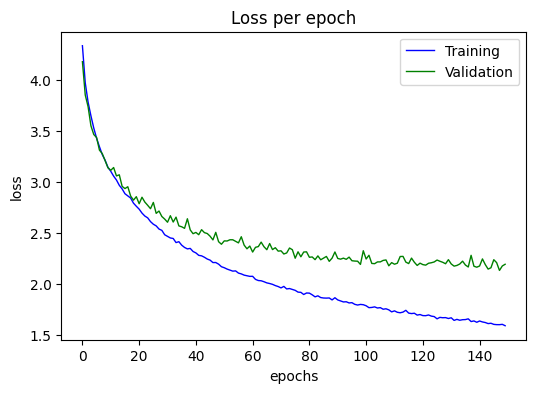

In [45]:
plt.figure(figsize=(6,4))
plt.plot(range(model2.trainedepoch), model2.trainloss, 'b', label = "Training",linewidth = '1')
plt.plot(range(model2.trainedepoch), model2.valloss, 'g', label = "Validation",linewidth = '1')

plt.title("Loss per epoch",)
plt.xlabel("epochs",)  
plt.ylabel("loss",)
plt.legend()
plt.show()

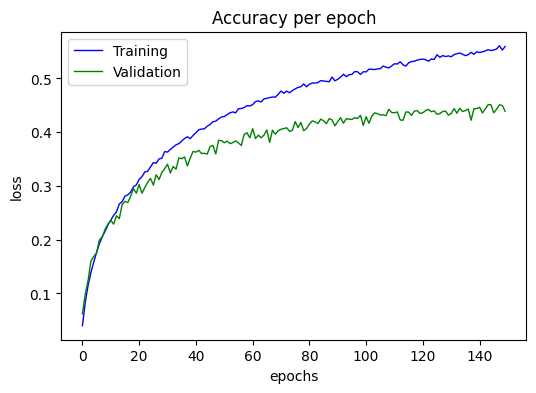

In [46]:
plt.figure(figsize=(6,4))
plt.plot(range(model2.trainedepoch), model2.trainacc, 'b', label = "Training",linewidth = '1')
plt.plot(range(model2.trainedepoch), model2.valacc, 'g', label = "Validation",linewidth = '1')

plt.title("Accuracy per epoch",)
plt.xlabel("epochs",)  
plt.ylabel("loss",)
plt.legend()
plt.show()

In [54]:
print(evaluate(trainloader, model2), evaluate(valloader, model2), evaluate(testloader, model2))

0.55895 0.4369 0.45


## MODEL 3: Custom ResNet

In [48]:
class ResNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv_layer_1 = torch.nn.Sequential(
                nn.Conv2d(in_channels=3, out_channels=64,kernel_size= 3,stride=1, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(),
            )
        self.conv_layer_2 = torch.nn.Sequential(
                nn.Conv2d(in_channels=64, out_channels=128,kernel_size=3,stride=1, padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(),
                torch.nn.MaxPool2d(kernel_size=2)
            )
        self.dropout_layer = nn.Dropout(p=0.25)

        self.res_layer1 = torch.nn.Sequential(
                nn.Conv2d(in_channels=128, out_channels=128,kernel_size=3,stride=1, padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(),
                nn.Conv2d(in_channels=128, out_channels=128,kernel_size=3,stride=1, padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(), 
            )
        self.dropout_layer = nn.Dropout(p=0.25)

        self.conv_layer_3 = torch.nn.Sequential(
                nn.Conv2d(in_channels=128, out_channels=256,kernel_size=3,stride=1, padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(),
                torch.nn.MaxPool2d(kernel_size=2)
            )

        self.conv_layer_4 = torch.nn.Sequential(
                nn.Conv2d(in_channels=256, out_channels=512,kernel_size=3,stride=1, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU(),
                torch.nn.MaxPool2d(kernel_size=2)
            )
        self.dropout_layer = nn.Dropout(p=0.25)

        self.res_layer2 = torch.nn.Sequential(
                nn.Conv2d(in_channels=512, out_channels=512,kernel_size=3,stride=1, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU(),
                nn.Conv2d(in_channels=512, out_channels=512,kernel_size=3,stride=1, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU(), 
            )
        self.dropout_layer=nn.Dropout(p=0.25)
        self.classifier = nn.Sequential(nn.MaxPool2d(2), 
                                        nn.Flatten(), 
                                        nn.Linear(512*2*2, 100))

    def forward(self, xb):
        out = self.conv_layer_1(xb)
        out = self.conv_layer_2(out)
        out = self.dropout_layer(out)
        out = self.res_layer1(out) + out
        out = self.dropout_layer(out)
        out = self.conv_layer_3(out)
        out = self.conv_layer_4(out)
        out = self.dropout_layer(out)
        out = self.res_layer2(out) + out
        out = self.dropout_layer(out)
        out = self.classifier(out)
        return out

model3 = ResNet()
model3 = model3.to(device)
summary(model3, (3, 32, 32))
model3.trainedepoch = 0
model3.trainloss, model3.valloss, model3.trainacc, model3.valacc = [], [], [], []

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,856
       BatchNorm2d-5          [-1, 128, 32, 32]             256
              ReLU-6          [-1, 128, 32, 32]               0
         MaxPool2d-7          [-1, 128, 16, 16]               0
           Dropout-8          [-1, 128, 16, 16]               0
            Conv2d-9          [-1, 128, 16, 16]         147,584
      BatchNorm2d-10          [-1, 128, 16, 16]             256
             ReLU-11          [-1, 128, 16, 16]               0
           Conv2d-12          [-1, 128, 16, 16]         147,584
      BatchNorm2d-13          [-1, 128, 16, 16]             256
             ReLU-14          [-1, 128,

In [49]:
optimizer = Adam(model3.parameters())
L = nn.CrossEntropyLoss()

In [50]:
train(trainloader, model3, optimizer, L, n_epochs=100, valdl=valloader)

Epoch 1, Train Loss: 5.0952, Train Accuracy: 0.0327,Val Loss: 4.3182, Val Accuracy: 0.0559
Epoch 2, Train Loss: 4.1096, Train Accuracy: 0.0884,Val Loss: 4.2813, Val Accuracy: 0.0795
Epoch 3, Train Loss: 3.7748, Train Accuracy: 0.1392,Val Loss: 3.6756, Val Accuracy: 0.1526
Epoch 4, Train Loss: 3.3927, Train Accuracy: 0.2042,Val Loss: 3.3629, Val Accuracy: 0.2070
Epoch 5, Train Loss: 3.1128, Train Accuracy: 0.2524,Val Loss: 3.2600, Val Accuracy: 0.2242
Epoch 6, Train Loss: 2.8409, Train Accuracy: 0.3000,Val Loss: 3.0536, Val Accuracy: 0.2574
Epoch 7, Train Loss: 2.6710, Train Accuracy: 0.3388,Val Loss: 2.7232, Val Accuracy: 0.3424
Epoch 8, Train Loss: 2.4271, Train Accuracy: 0.3792,Val Loss: 2.6858, Val Accuracy: 0.3258
Epoch 9, Train Loss: 2.2923, Train Accuracy: 0.4125,Val Loss: 2.5772, Val Accuracy: 0.3651
Epoch 10, Train Loss: 2.1964, Train Accuracy: 0.4286,Val Loss: 2.3812, Val Accuracy: 0.4005
Epoch 11, Train Loss: 2.0685, Train Accuracy: 0.4570,Val Loss: 2.4040, Val Accuracy: 0.38

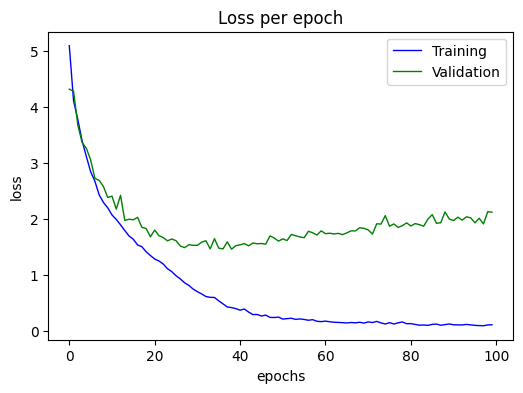

In [51]:
plt.figure(figsize=(6,4))
plt.plot(range(model3.trainedepoch), model3.trainloss, 'b', label = "Training",linewidth = '1')
plt.plot(range(model3.trainedepoch), model3.valloss, 'g', label = "Validation",linewidth = '1')

plt.title("Loss per epoch",)
plt.xlabel("epochs",)  
plt.ylabel("loss",)
plt.legend()
plt.show()

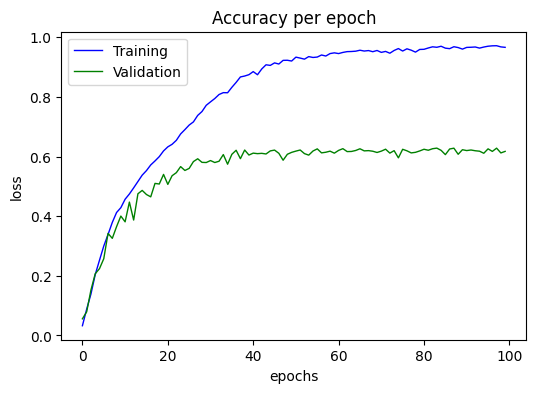

In [66]:
plt.figure(figsize=(6,4))
plt.plot(range(model3.trainedepoch), model3.trainacc, 'b', label = "Training",linewidth = '1')
plt.plot(range(model3.trainedepoch), model3.valacc, 'g', label = "Validation",linewidth = '1')

plt.title("Accuracy per epoch",)
plt.xlabel("epochs",)  
plt.ylabel("loss",)
plt.legend()
plt.show()

In [53]:
print(evaluate(trainloader, model3), evaluate(valloader, model3), evaluate(testloader, model3))

0.9839 0.6193 0.6305


## MODEL 4: ResNet18

In [60]:
model4 = models.resnet18(pretrained=True)
model4 = model4.to(device)
features4 = model4.fc.in_features

model4.fc = nn.Linear(features4, 100)
model4.fc = model4.fc.cuda() if device else model4.fc

summary(model4, (3, 32, 32))
model4.trainedepoch = 0
model4.trainloss, model4.valloss, model4.trainacc, model4.valacc = [], [], [], []

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

In [61]:
optimizer = Adam(model4.parameters())
L = nn.CrossEntropyLoss()

In [62]:
train(trainloader, model4, optimizer, L, n_epochs=100, valdl=valloader)

Epoch 1, Train Loss: 2.9863, Train Accuracy: 0.2692,Val Loss: 2.5610, Val Accuracy: 0.3425
Epoch 2, Train Loss: 2.1576, Train Accuracy: 0.4236,Val Loss: 2.3400, Val Accuracy: 0.3936
Epoch 3, Train Loss: 1.8755, Train Accuracy: 0.4857,Val Loss: 2.2763, Val Accuracy: 0.4106
Epoch 4, Train Loss: 1.7137, Train Accuracy: 0.5251,Val Loss: 2.1944, Val Accuracy: 0.4308
Epoch 5, Train Loss: 1.5800, Train Accuracy: 0.5560,Val Loss: 2.0859, Val Accuracy: 0.4621
Epoch 6, Train Loss: 1.4682, Train Accuracy: 0.5814,Val Loss: 2.0467, Val Accuracy: 0.4745
Epoch 7, Train Loss: 1.3522, Train Accuracy: 0.6107,Val Loss: 2.1257, Val Accuracy: 0.4633
Epoch 8, Train Loss: 1.2685, Train Accuracy: 0.6320,Val Loss: 1.9752, Val Accuracy: 0.4967
Epoch 9, Train Loss: 1.1912, Train Accuracy: 0.6516,Val Loss: 2.1751, Val Accuracy: 0.4649
Epoch 10, Train Loss: 1.1230, Train Accuracy: 0.6696,Val Loss: 1.9948, Val Accuracy: 0.5041
Epoch 11, Train Loss: 1.0286, Train Accuracy: 0.6929,Val Loss: 1.9360, Val Accuracy: 0.51

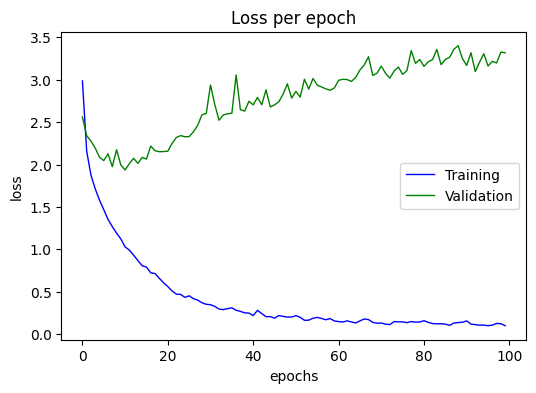

In [67]:
plt.figure(figsize=(6,4))
plt.plot(range(model4.trainedepoch), model4.trainloss, 'b', label = "Training",linewidth = '1')
plt.plot(range(model4.trainedepoch), model4.valloss, 'g', label = "Validation",linewidth = '1')

plt.title("Loss per epoch",)
plt.xlabel("epochs",)  
plt.ylabel("loss",)
plt.legend()
plt.show()

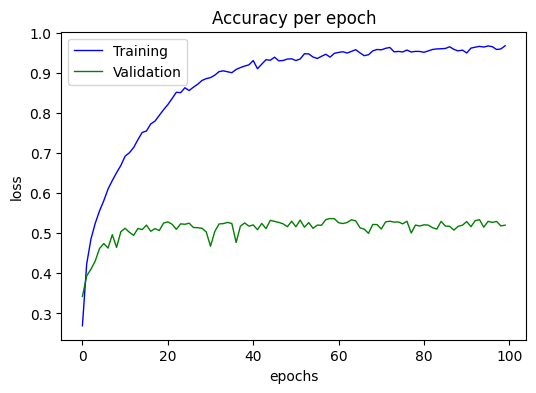

In [70]:
plt.figure(figsize=(6,4))
plt.plot(range(model4.trainedepoch), model4.trainacc, 'b', label = "Training",linewidth = '1')
plt.plot(range(model4.trainedepoch), model4.valacc, 'g', label = "Validation",linewidth = '1')

plt.title("Accuracy per epoch",)
plt.xlabel("epochs",)  
plt.ylabel("loss",)
plt.legend()
plt.show()

In [69]:
print(evaluate(trainloader, model4), evaluate(valloader, model4), evaluate(testloader, model4))

0.94905 0.5188 0.5196


## MODEL 5: ResNet50

In [71]:
model5 = models.resnet50(pretrained=True)
model5 = model5.to(device)
features5 = model5.fc.in_features

model5.fc = nn.Linear(features5, 100)
model5.fc = model5.fc.cuda() if device else model4.fc

summary(model5, (3, 32, 32))
model5.trainedepoch = 0
model5.trainloss, model5.valloss, model5.trainacc, model5.valacc = [], [], [], []

C:\Users\yigii\anaconda3\envs\deeplearning\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]           4,096
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]          16,384
      BatchNorm2d-12            [-1, 256, 8, 8]             512
           Conv2d-13            [-1, 256, 8, 8]          16,384
      BatchNorm2d-14            [-1, 25

In [72]:
optimizer = Adam(model5.parameters())
L = nn.CrossEntropyLoss()

In [73]:
train(trainloader, model5, optimizer, L, n_epochs=100, valdl=valloader)

Epoch 1, Train Loss: 2.8902, Train Accuracy: 0.2878,Val Loss: 2.4702, Val Accuracy: 0.3624
Epoch 2, Train Loss: 2.0493, Train Accuracy: 0.4471,Val Loss: 2.0813, Val Accuracy: 0.4428
Epoch 3, Train Loss: 1.7747, Train Accuracy: 0.5094,Val Loss: 2.0445, Val Accuracy: 0.4562
Epoch 4, Train Loss: 1.5650, Train Accuracy: 0.5612,Val Loss: 1.8902, Val Accuracy: 0.4932
Epoch 5, Train Loss: 1.4315, Train Accuracy: 0.5908,Val Loss: 1.8195, Val Accuracy: 0.5174
Epoch 6, Train Loss: 1.3147, Train Accuracy: 0.6195,Val Loss: 1.7687, Val Accuracy: 0.5322
Epoch 7, Train Loss: 1.2226, Train Accuracy: 0.6424,Val Loss: 1.8697, Val Accuracy: 0.5161
Epoch 8, Train Loss: 1.1204, Train Accuracy: 0.6698,Val Loss: 1.6934, Val Accuracy: 0.5480
Epoch 9, Train Loss: 1.0433, Train Accuracy: 0.6893,Val Loss: 1.8211, Val Accuracy: 0.5281
Epoch 10, Train Loss: 0.9953, Train Accuracy: 0.7039,Val Loss: 1.9852, Val Accuracy: 0.5127
Epoch 11, Train Loss: 0.9195, Train Accuracy: 0.7239,Val Loss: 1.8055, Val Accuracy: 0.54

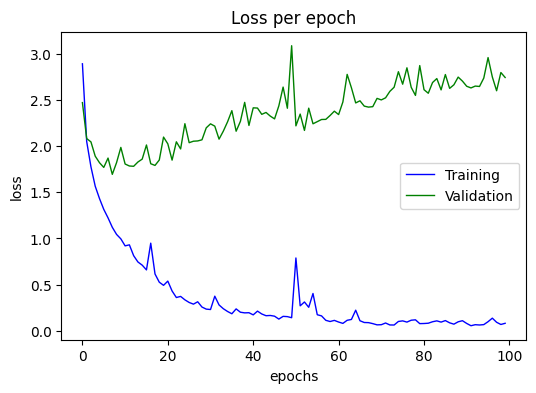

In [74]:
plt.figure(figsize=(6,4))
plt.plot(range(model5.trainedepoch), model5.trainloss, 'b', label = "Training",linewidth = '1')
plt.plot(range(model5.trainedepoch), model5.valloss, 'g', label = "Validation",linewidth = '1')

plt.title("Loss per epoch",)
plt.xlabel("epochs",)  
plt.ylabel("loss",)
plt.legend()
plt.show()

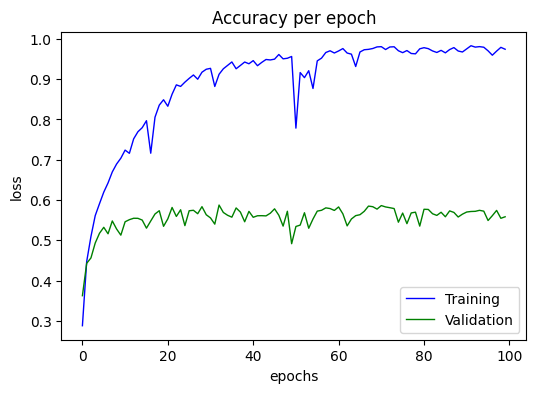

In [77]:
plt.figure(figsize=(6,4))
plt.plot(range(model5.trainedepoch), model5.trainacc, 'b', label = "Training",linewidth = '1')
plt.plot(range(model5.trainedepoch), model5.valacc, 'g', label = "Validation",linewidth = '1')

plt.title("Accuracy per epoch",)
plt.xlabel("epochs",)  
plt.ylabel("loss",)
plt.legend()
plt.show()

In [78]:
print(evaluate(trainloader, model5), evaluate(valloader, model5), evaluate(testloader, model5))

0.965175 0.5575 0.5614


## MODEL 6: ResNet50(Pretrained)

In [8]:
torch.cuda.empty_cache()

In [9]:
model6 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
features6 = model6.fc.in_features

for name, param in model6.named_parameters():
    if 'bn' not in name:
        param.requires_grad = False
    
model6.fc = nn.Linear(features6, 100)

# Define the upsampled layers
upsample = nn.Sequential(
    nn.Upsample(scale_factor=2, mode='nearest')
)

# Combine the first model and the upsampled layers
model6 = nn.Sequential(upsample, model6)

model6 = model6.to(device)
summary(model6, (3, 32, 32))

model6.trainedepoch = 0
model6.trainloss, model6.valloss, model6.trainacc, model6.valacc = [], [], [], []

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
          Upsample-1            [-1, 3, 64, 64]               0
            Conv2d-2           [-1, 64, 32, 32]           9,408
       BatchNorm2d-3           [-1, 64, 32, 32]             128
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6           [-1, 64, 16, 16]           4,096
       BatchNorm2d-7           [-1, 64, 16, 16]             128
              ReLU-8           [-1, 64, 16, 16]               0
            Conv2d-9           [-1, 64, 16, 16]          36,864
      BatchNorm2d-10           [-1, 64, 16, 16]             128
             ReLU-11           [-1, 64, 16, 16]               0
           Conv2d-12          [-1, 256, 16, 16]          16,384
      BatchNorm2d-13          [-1, 256, 16, 16]             512
           Conv2d-14          [-1, 256,

In [10]:
optimizer = Adam(model6.parameters())
L = nn.CrossEntropyLoss()

In [11]:
# train(trainloader, model6, optimizer, L, n_epochs=100, valdl=valloader)
train(trainloader, model6, optimizer, L, n_epochs=100, valdl=valloader)

Epoch 1, Train Loss: 2.7587, Train Accuracy: 0.3569,Val Loss: 1.9222, Val Accuracy: 0.4893
Epoch 2, Train Loss: 1.5713, Train Accuracy: 0.5705,Val Loss: 1.4988, Val Accuracy: 0.5840
Epoch 3, Train Loss: 1.2593, Train Accuracy: 0.6441,Val Loss: 1.3132, Val Accuracy: 0.6274
Epoch 4, Train Loss: 1.0684, Train Accuracy: 0.6878,Val Loss: 1.2236, Val Accuracy: 0.6521
Epoch 5, Train Loss: 0.9474, Train Accuracy: 0.7184,Val Loss: 1.1500, Val Accuracy: 0.6687
Epoch 6, Train Loss: 0.8544, Train Accuracy: 0.7445,Val Loss: 1.1225, Val Accuracy: 0.6776
Epoch 7, Train Loss: 0.7763, Train Accuracy: 0.7638,Val Loss: 1.0823, Val Accuracy: 0.6906
Epoch 8, Train Loss: 0.7089, Train Accuracy: 0.7832,Val Loss: 1.0499, Val Accuracy: 0.6992
Epoch 9, Train Loss: 0.6537, Train Accuracy: 0.7977,Val Loss: 1.0373, Val Accuracy: 0.7010
Epoch 10, Train Loss: 0.6126, Train Accuracy: 0.8102,Val Loss: 1.0079, Val Accuracy: 0.7093
Epoch 11, Train Loss: 0.5688, Train Accuracy: 0.8215,Val Loss: 1.0078, Val Accuracy: 0.71

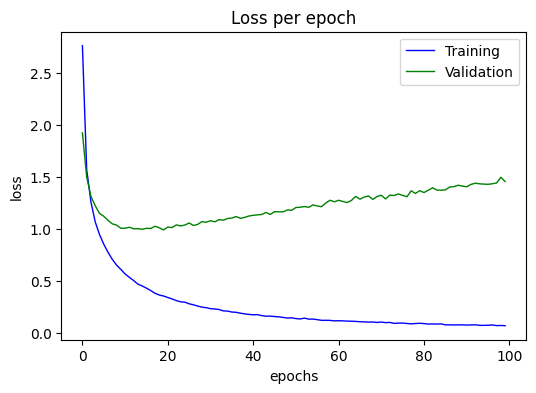

In [12]:
plt.figure(figsize=(6,4))
plt.plot(range(model6.trainedepoch), model6.trainloss, 'b', label = "Training",linewidth = '1')
plt.plot(range(model6.trainedepoch), model6.valloss, 'g', label = "Validation",linewidth = '1')

plt.title("Loss per epoch",)
plt.xlabel("epochs",)  
plt.ylabel("loss",)
plt.legend()
plt.show()

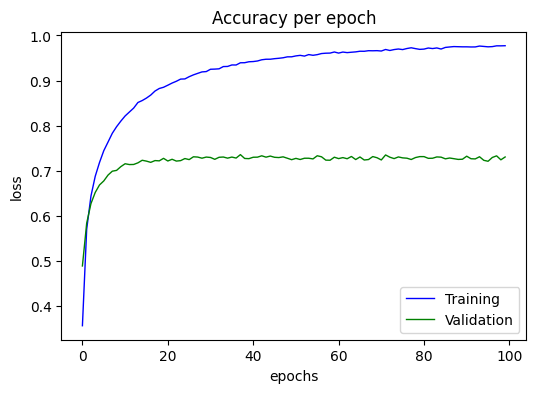

In [13]:
plt.figure(figsize=(6,4))
plt.plot(range(model6.trainedepoch), model6.trainacc, 'b', label = "Training",linewidth = '1')
plt.plot(range(model6.trainedepoch), model6.valacc, 'g', label = "Validation",linewidth = '1')

plt.title("Accuracy per epoch",)
plt.xlabel("epochs",)  
plt.ylabel("loss",)
plt.legend()
plt.show()

In [14]:
print(evaluate(trainloader, model6), evaluate(valloader, model6), evaluate(testloader, model6))

0.9839 0.7371 0.7239
